## Columnes
genre: The genre in which the track belongs.

artist_name: The artists' names who performed the track

track_name: Name of the track

track_id: The Spotify ID for the track

popularity: The popularity of a track is a value between 0 and 100

acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic

danceability: Danceability describes how suitable a track is for dancing based

duration_ms: The track length in milliseconds

energy: Measure of intensity and activity from 0.0 to 1.0

instrumentalness: Predicts whether a track contains no vocals (nearer 1=no vocals)

key: The key the track is in

liveness: Detects the presence of an audience in the recording (higher 0.8=live)

loudness: The overall loudness of a track in decibels (dB)

mode: Mode indicates the scale (major or minor) of a track

speechiness: Speechiness detects the presence of spoken words in a track

tempo: The overall estimated tempo of a track in beats per minute

time_signature: An estimated time signature

valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track

In [107]:
##A)Carregar llibreries
import pandas as pd ###py -m pip install pandas
import numpy as np ###py -m pip install numypy

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD ###py -m pip install scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN, MiniBatchKMeans 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

from yellowbrick.cluster import KElbowVisualizer ##py -m pip install yellowbrick

import seaborn as sns ##py -m pip install seaborn

import random

import matplotlib.pyplot as plt ##py -m pip install matplotlib

from scipy.spatial.distance import euclidean

# B) Carregar dataset

In [11]:
##B)Carregar el dataset
df = pd.read_csv('SpotifyFeatures.csv')
#print(df.head()) #Mostra 5 rows
print(df.info()) #Mostra el tipus de columns: df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

# C) Preparar dades

In [24]:
##C)Preparar dades
#1) Tractar duplicats
#Quantitat duplicats
print("Quantitat de dupplicats:", df.duplicated(subset="track_id", keep="first").sum())
#print(df[df.duplicated(subset="track_id", keep=False)]) Veure files dels duplicats

#Treure duplicats (files)
df.drop_duplicates(subset="track_id", keep="first", inplace=True)
print("Quantitat de dupplicats després:", df.duplicated(subset="track_id", keep="first").sum())
print("New shape sense duplicats:", df.shape)

Quantitat de dupplicats: 55951
Quantitat de dupplicats després: 0
New shape sense duplicats: (176774, 18)


In [25]:
#2) Corretgir valors errònis (impossibles)
#Comprovar valors de key, mode i time_signature
#print("Key values:", df['key'].value_counts())
#print("Mode values:", df["mode"].value_counts())
#print("Time_signature values:", df["time_signature"].value_counts())
#print("Genre values::", df["genre"].value_counts())

#Eliminar key: "0/4" (impossible)
print("Quantitat de '0/4'abans:", (df["time_signature"] == "0/4").sum()) #Quantitat key: "0/4"
df = df[df["time_signature"] != "0/4"]
print("Quantitat de '0/4' després:", (df["time_signature"] == "0/4").sum())
print("New shape sense '0/4':", df.shape)

#Eliminar NaN
print("Quantitat de Nan abans:", df.isna().sum().sum()) #Quantitat Nan en tot df
#print("NaN per features:", df.isna().sum())
df.dropna(axis=0, inplace=True) #
print("Quantitat de Nan després:", df.isna().sum().sum())
print("New shape sense Nan:", df.shape)

Quantitat de '0/4'abans: 6
Quantitat de '0/4' després: 0
New shape sense '0/4': (176768, 18)
Quantitat de Nan abans: 1
Quantitat de Nan després: 0
New shape sense Nan: (176767, 18)


In [26]:
#3) Eliminar columnes 
#Reiniciar index en dataframe
df.reset_index(drop=True, inplace=True)

#Guardar columnes: 'track_name', 'artist_name'
track_name = df[["track_name"]]
artist_name = df[["artist_name"]]

#Drop olumnes: 'artist_name','track_name','track_id 
df.drop(['artist_name','track_name','track_id'], axis=1, inplace=True) #Elimina les columnes modificant df og
print(f"Nova shape sense artist_name, track_name, track_id: {df.shape}") #Mostra rowsxcolumns

num_col = df.select_dtypes(exclude="object").columns
cat_col = df.select_dtypes(include="object").columns

Nova shape sense artist_name, track_name, track_id: (176767, 15)


In [27]:
#4)Codificar columnes no numèriques
"""
#METODE0 Totes features amb frequencia
freq = df["key"].value_counts(normalize=True)
df["key"] = df["key"].map(freq)
#Codificar columna mode 
freq = df["mode"].value_counts(normalize=True)
df["mode"] = df["mode"].map(freq)
#Codificar columna time_signature
freq = df["time_signature"].value_counts(normalize=True)
df["time_signature"] = df["time_signature"].map(freq)
#Codificar columna genre
freq = df["genre"].value_counts(normalize=True)
df["genre"] = df["genre"].map(freq)
"""
"""
#METODE1 Totes features amb OneHotEncoder 
df1 = df.copy(deep=True)
df_temp = df1[['genre','key', 'mode', 'time_signature']].copy()
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = enc.fit_transform(df_temp)
feature_names = enc.get_feature_names_out(['genre','key', 'mode', 'time_signature'])
encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df1.index)
df1 = pd.concat([df1.drop(['genre','key', 'mode', 'time_signature'], axis=1), encoded_df], axis=1)
print("Nova shape df1:", df1.shape)
print("Noves columnas:", df1.columns)

#METODE2 Genre amb OneHotEncoder i resta amb Diccionari ordenat
df2 = df.copy(deep=True)
mode_dict = {'Major' : 1, 'Minor' : 0}
key_dict = {'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
        'F#' : 7, 'G' : 9, 'G#' : 10, 'A' : 11, 'A#' : 12, 'B' : 12}
time_signature_dict = {'1/4' : 1, '3/4' : 3, '4/4' :4, "5/4": 5}
#Codificar columna key 
df2["key"] = df2["key"].map(key_dict)
#Codificar columna mode 
df2["mode"] = df2["mode"].map(mode_dict)
#Codificar columna time_signature
df2["time_signature"] = df2["time_signature"].map(time_signature_dict)
#Codificar columna genre
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_temp = df2[['genre']].copy()
encoded_array = enc.fit_transform(df_temp)
feature_names = enc.get_feature_names_out(['genre'])
encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df1.index)
df2 = pd.concat([df2.drop(['genre'], axis=1), encoded_df], axis=1)
print("Nova shape df2:", df2.shape)
print("Noves columnas:", df2.columns)
"""
#METODE3 Genre amb OneHotEncoder i resta amb frequencia
df3 = df.copy(deep=True)
freq = df3["key"].value_counts(normalize=True)
df3["key"] = df3["key"].map(freq)
#Codificar columna mode 
freq = df["mode"].value_counts(normalize=True)
df3["mode"] = df3["mode"].map(freq)
#Codificar columna time_signature
freq = df3["time_signature"].value_counts(normalize=True)
df3["time_signature"] = df3["time_signature"].map(freq)
#Codificar columna genre
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_temp = df3[['genre']].copy()
encoded_array = enc.fit_transform(df_temp)
feature_names = enc.get_feature_names_out(['genre'])
encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df3.index)
df3 = pd.concat([df3.drop(['genre'], axis=1), encoded_df], axis=1)
print("Nova shape df3:", df3.shape)
print("Noves columnas:", df3.columns)

Nova shape df3: (176767, 41)
Noves columnas: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'genre_A Capella',
       'genre_Alternative', 'genre_Anime', 'genre_Blues',
       'genre_Children's Music', 'genre_Children’s Music', 'genre_Classical',
       'genre_Comedy', 'genre_Country', 'genre_Dance', 'genre_Electronic',
       'genre_Folk', 'genre_Hip-Hop', 'genre_Indie', 'genre_Jazz',
       'genre_Movie', 'genre_Opera', 'genre_Pop', 'genre_R&B', 'genre_Rap',
       'genre_Reggae', 'genre_Reggaeton', 'genre_Rock', 'genre_Ska',
       'genre_Soul', 'genre_Soundtrack', 'genre_World'],
      dtype='object')


(array([[<Axes: title={'center': 'popularity'}>,
         <Axes: title={'center': 'acousticness'}>,
         <Axes: title={'center': 'danceability'}>,
         <Axes: title={'center': 'duration_ms'}>,
         <Axes: title={'center': 'energy'}>,
         <Axes: title={'center': 'instrumentalness'}>],
        [<Axes: title={'center': 'key'}>,
         <Axes: title={'center': 'liveness'}>,
         <Axes: title={'center': 'loudness'}>,
         <Axes: title={'center': 'mode'}>,
         <Axes: title={'center': 'speechiness'}>,
         <Axes: title={'center': 'tempo'}>],
        [<Axes: title={'center': 'time_signature'}>,
         <Axes: title={'center': 'valence'}>,
         <Axes: title={'center': 'genre_A Capella'}>,
         <Axes: title={'center': 'genre_Alternative'}>,
         <Axes: title={'center': 'genre_Anime'}>,
         <Axes: title={'center': 'genre_Blues'}>],
        [<Axes: title={'center': "genre_Children's Music"}>,
         <Axes: title={'center': 'genre_Children’s Mu

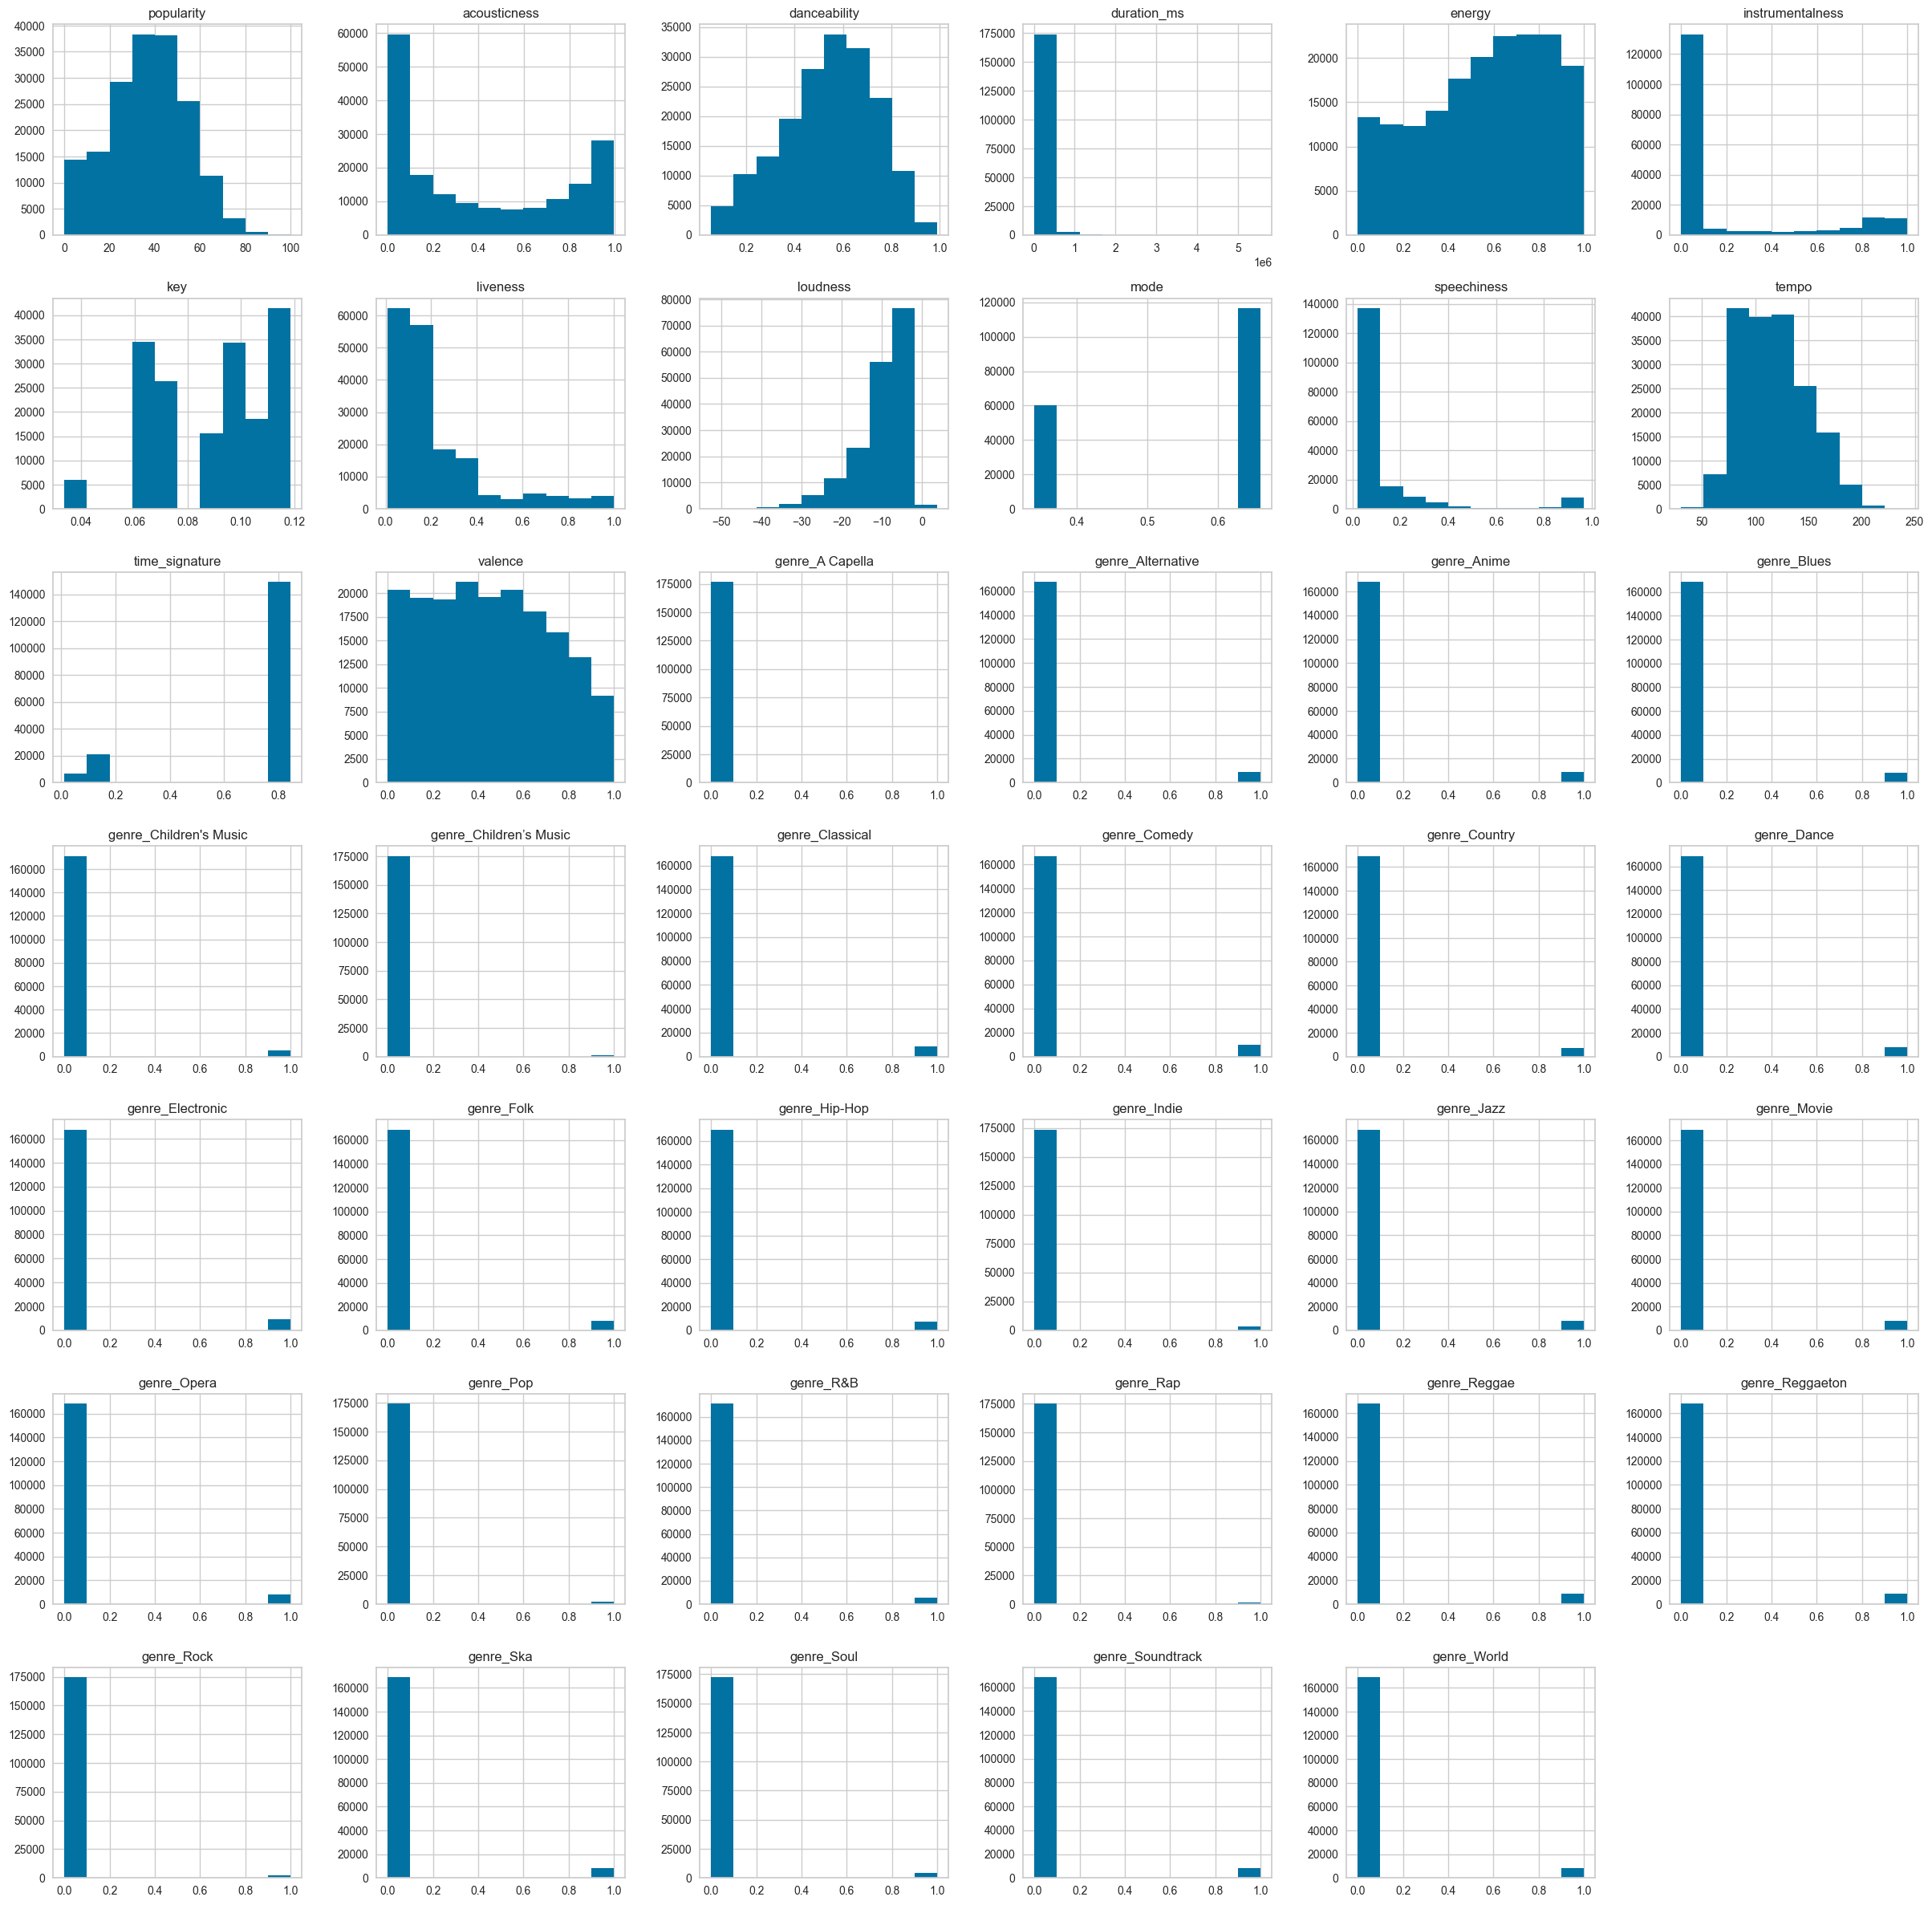

In [28]:
#5) Mirar dist
df3.hist(figsize=(30, 30)), 

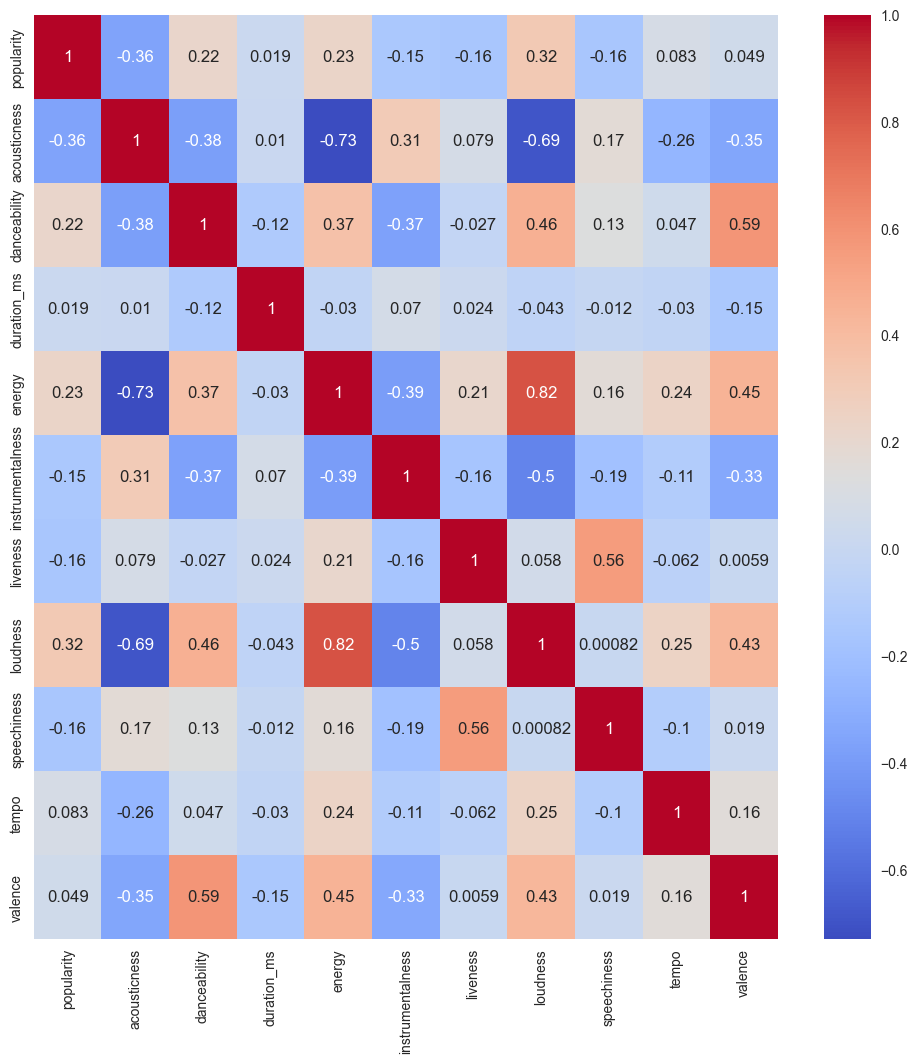

In [29]:
#6) Mirar correlació (pearson)
corr_matrix3 = df3[num_col].corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr_matrix3, annot=True, cmap='coolwarm')
plt.show()

In [30]:
#7) Escalar columnes
scaler = StandardScaler()
df3_scal = scaler.fit_transform(df3)
#data_scal = pd.DataFrame(data=scaler.fit_transform(data), columns=data.columns)

# D) Establir model

## 1) KMeans

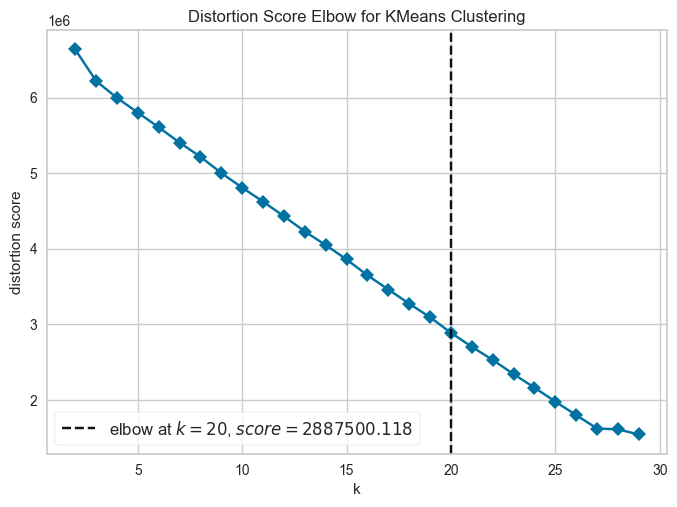

In [ ]:
#DATASET3
#1) Calcular k millor
model = KMeans(n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion') #default distance_metric: euclidean
visualizer.fit(df3_scal)       
#visualizer.show() #Quitar en py
#visualizer.show(outpath="kmeans.png")
k = visualizer.elbow_value_ #millor k
#2) Entrenar i predir amb KMEANS
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
#kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
kmeans3 = kmeans.fit_predict(df3_scal) #Mateix que: kmeans.labels__
#data_scal["cluster"] = pred

## 2) Minibatch

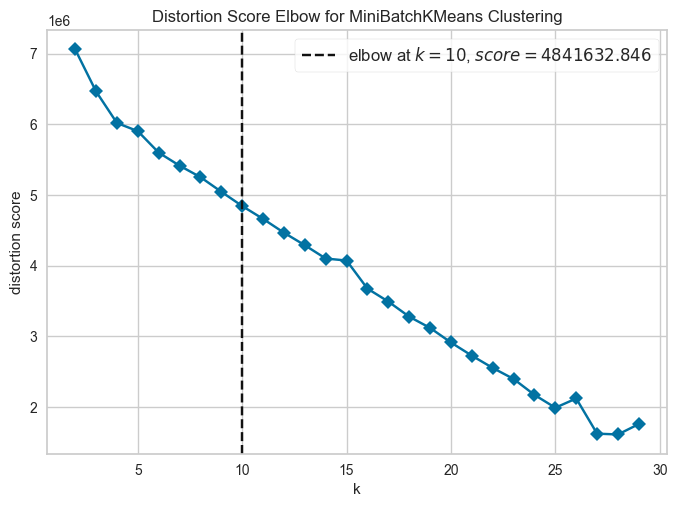

In [ ]:
#DATASET3
#1) Calcular k millor
model = MiniBatchKMeans(n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion') #default distance_metric: euclidean
visualizer.fit(df3_scal)       
#visualizer.show() #Quitar en py
visualizer.show(outpath="mini.png")
k = visualizer.elbow_value_ #millor k

#2) Entrenar i predir amb KMEANS
kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
#kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0)
mini3 = kmeans.fit_predict(df3_scal) #Mateix que: kmeans.labels__
#data_scal["cluster"] = pred

## 3) DBSCAN

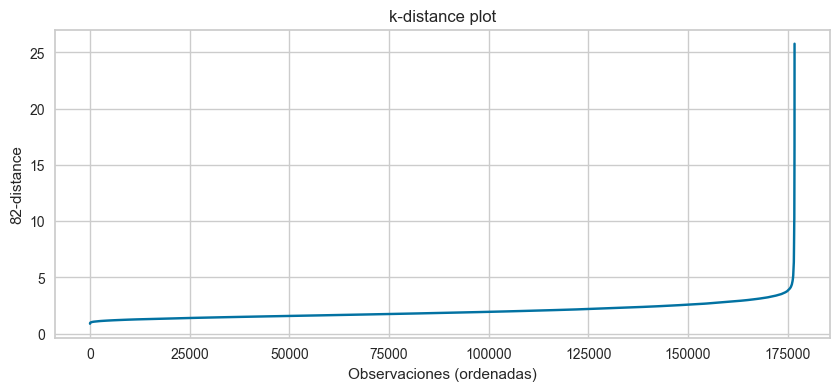

3.803300516624388


In [ ]:
#DATASET3
#1) Calcular eps
min_samples = 2 * df3_scal.shape[1]
nn = NearestNeighbors(n_neighbors=min_samples).fit(df3_scal) #default algorithm: auto; most appropiate, default metric: minkowski
dists, _ = nn.kneighbors(df3_scal)
kdist = np.sort(dists[:, -1])
plt.figure(figsize=(10,4))
plt.plot(kdist, label=f'{min_samples}-distance sorted')
plt.title('k-distance plot')
plt.xlabel('Observaciones (ordenadas)')
plt.ylabel(f'{min_samples}-distance')
plt.savefig("dbscan.png")
plt.show()
print(kdist[175000])

In [ ]:
#2) Entrenar i predir amb DBSCAN
min_samples = 2 * df3_scal.shape[1]
db = DBSCAN(eps=4.2, min_samples=min_samples, n_jobs=-1,) #default algorithm: auto of NearestNeighbours; most appropiate
dbscan3 = db.fit_predict(df3_scal)
#print(calinski_harabasz_score(df3_scal, dbscan3), davies_bouldin_score(df3_scal, dbscan3))

23508.554166407263 0.8136070812598387


## 4) HDBSCAN

In [88]:
#DATASET3
#1) Entrenar i predir amb HDBSCAN
min_samples = 2 * df3_scal.shape[1]
db = HDBSCAN(min_cluster_size=min_samples, min_samples=min_samples, n_jobs=-1, store_centers="centroid") #default metric: euclidean
hdbscan3 = db.fit_predict(df3_scal)

## 5) Gaussian Mixture

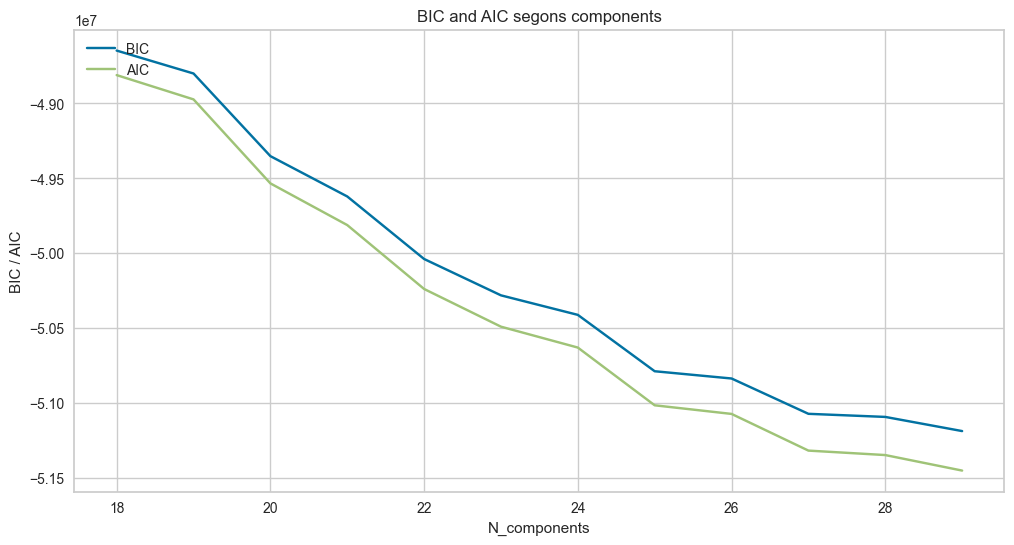

In [93]:
#DATASET3
#1) Trobar n_components
n_components_range = range(18, 30)
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, n_init=10, random_state=0)
    gmm.fit(df3_scal)
    bics.append(gmm.bic(df3_scal))
    aics.append(gmm.aic(df3_scal))

plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bics, label='BIC')
plt.plot(n_components_range, aics, label='AIC')
plt.xlabel('N_components')
plt.ylabel('BIC / AIC')
plt.legend(loc=2)
plt.title('BIC and AIC segons components')
plt.savefig("gm.png")
plt.show()

In [94]:
#DATASET3
#2) Entrenar i predir amb GM
gm = GaussianMixture(n_components=25, n_init=10, random_state=0) #default covariance_type: full 
gm3 = gm.fit_predict(df3_scal)

# E) Evaluar models

In [95]:
#KMEANS
print(calinski_harabasz_score(df3_scal, kmeans3), davies_bouldin_score(df3_scal, kmeans3))

14046.160854717451 1.611511491975799


In [96]:
#Minibatch
print(calinski_harabasz_score(df3_scal, mini3), davies_bouldin_score(df3_scal, mini3))

9758.977924160143 2.1654833427001177


In [97]:
#DBSCAN
print(calinski_harabasz_score(df3_scal, dbscan3), davies_bouldin_score(df3_scal, dbscan3))

23508.554166407263 0.8136070812598387


In [98]:
#HDBSCAN
print(calinski_harabasz_score(df3_scal, hdbscan3), davies_bouldin_score(df3_scal, hdbscan3))

23593.55618740797 0.7964359381597638


In [99]:
#GaussianMixture
print(calinski_harabasz_score(df3_scal, gm3), davies_bouldin_score(df3_scal, gm3))

19628.45616460746 1.1394017057470056


In [102]:
set(gm3)

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24)}

# F) Visualitzar predicció

In [103]:
# Crear sampled dataset per proves més ràpides
# Samplearem 25% de les dades per a proves
sample_size = int(len(df) * 0.15)
sample_indices = np.random.RandomState(42).choice(len(df), sample_size, replace=False)

df3_sample = df3_scal[sample_indices]

#pred= pred[sample_indices]
print("Mida orignal:", df.shape)
print("Mida 20%:", df3_sample.shape)

Mida orignal: (176767, 15)
Mida 20%: (26515, 41)


## 1) HDBSCAN

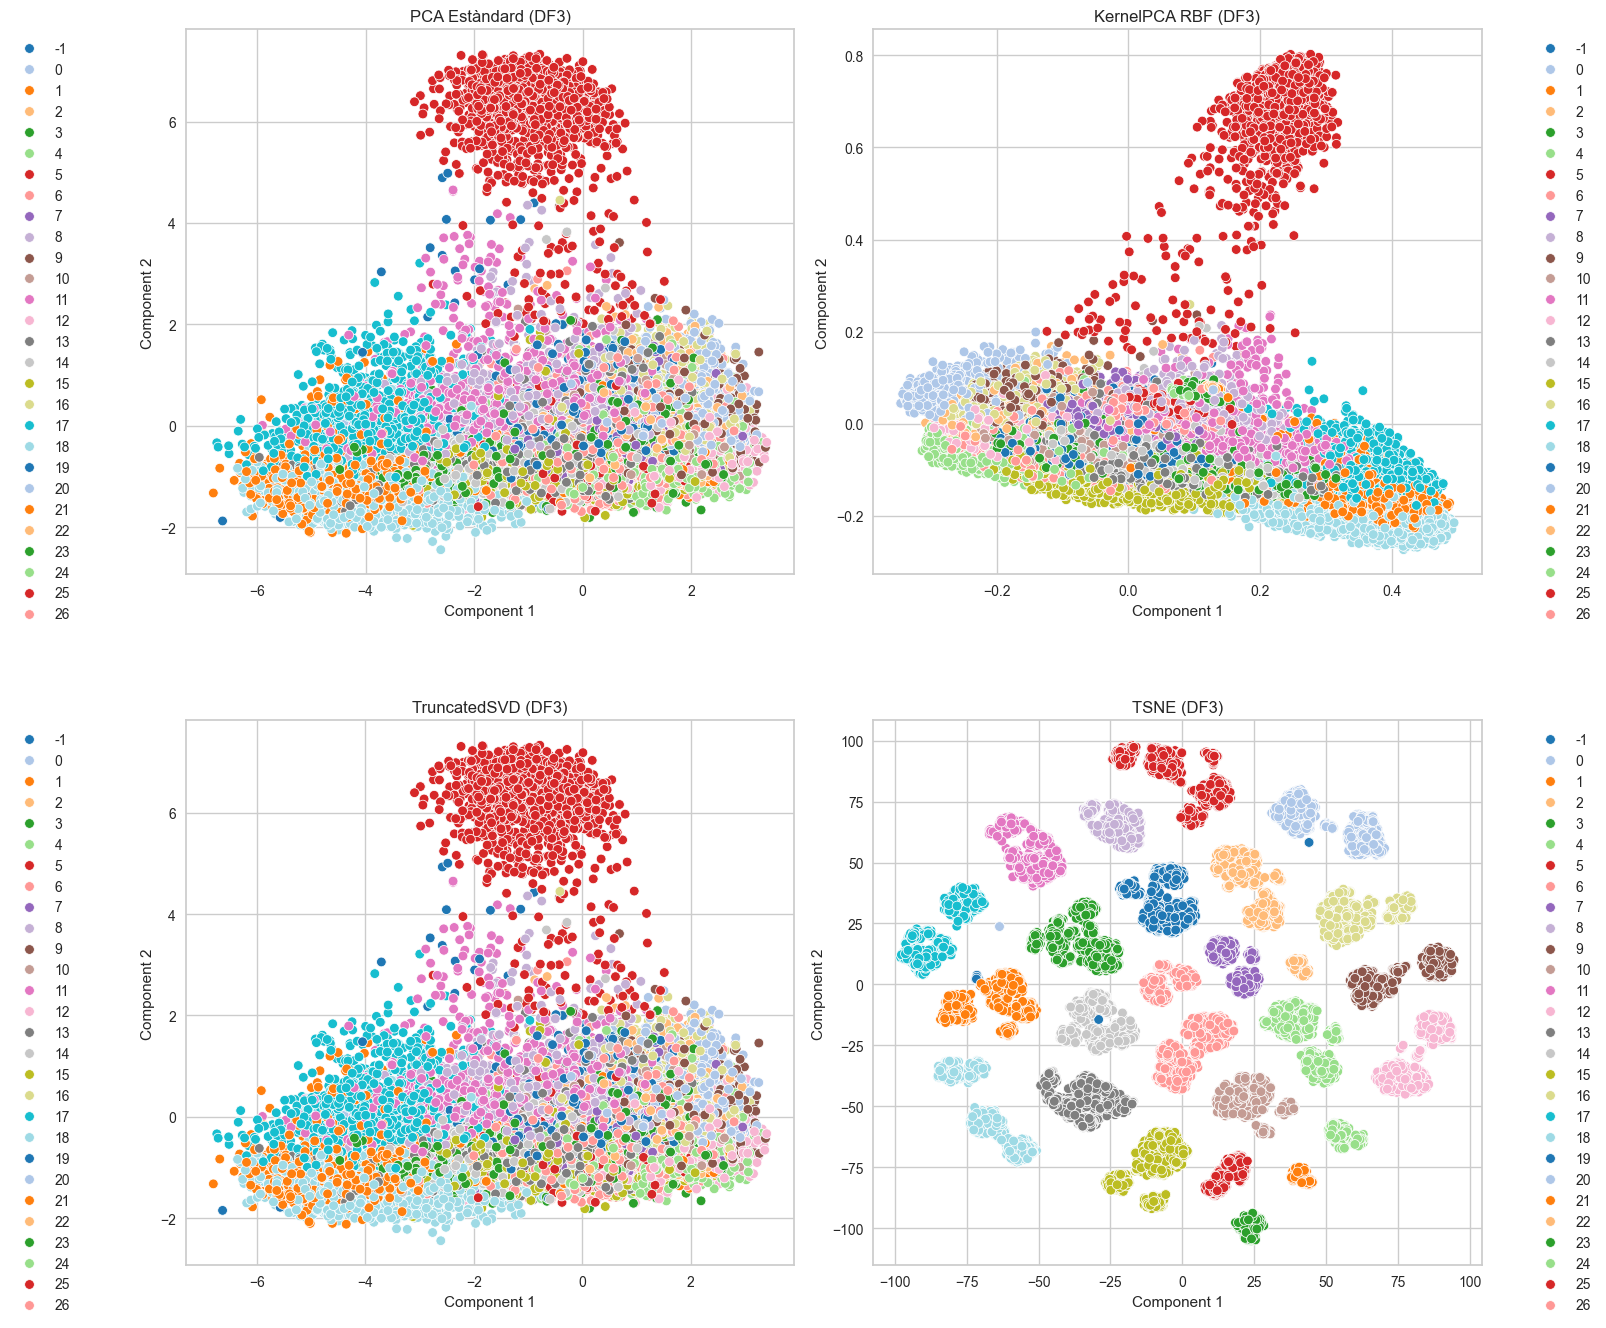

In [104]:
#DATASET3
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. PCA Estàndard
pca_sample = PCA(n_components=2, random_state=42)
df3_sample_pca = pca_sample.fit_transform(df3_sample)

df3_sample_pca_2 = pd.DataFrame(data=df3_sample_pca, columns=['Component 1', 'Component 2'])
df3_sample_pca_2["Cluster"] = hdbscan3[sample_indices]
sns.scatterplot(data=df3_sample_pca_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[0, 0])
axes[0, 0].set_title('PCA Estàndard (DF3)')
axes[0, 0].legend(loc=2, bbox_to_anchor=(-0.3, 1))

# 2. KernelPCA RBF
kpca_sample = KernelPCA(n_components=2, kernel='rbf', random_state=42, n_jobs=-1)
df3_sample_kpca = kpca_sample.fit_transform(df3_sample)

df3_sample_kpca_2 = pd.DataFrame(data=df3_sample_kpca, columns=['Component 1', 'Component 2'])
df3_sample_kpca_2["Cluster"] = hdbscan3[sample_indices]
sns.scatterplot(data=df3_sample_kpca_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[0, 1])
axes[0, 1].set_title('KernelPCA RBF (DF3)')
axes[0, 1].legend(loc=1, bbox_to_anchor=(1.2, 1))

# 3. TruncatedSVD
tsvd_sample = TruncatedSVD(n_components=2, random_state=42)
df3_sample_tsvd = tsvd_sample.fit_transform(df3_sample)

df3_sample_tsvd_2 = pd.DataFrame(data=df3_sample_tsvd, columns=['Component 1', 'Component 2'])
df3_sample_tsvd_2["Cluster"] = hdbscan3[sample_indices]
sns.scatterplot(data=df3_sample_tsvd_2, x='Component 1', y='Component 2', hue='Cluster', 
               palette='tab20', ax=axes[1, 0])
axes[1, 0].set_title('TruncatedSVD (DF3)')
axes[1, 0].legend(loc=2, bbox_to_anchor=(-0.3, 1))

# 4. TSNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42)
df3_sample_tsne = tsne.fit_transform(df3_sample)
df3_sample_tsne_2 = pd.DataFrame(data=df3_sample_tsne, columns=['Component 1', 'Component 2'])
df3_sample_tsne_2["Cluster"] = hdbscan3[sample_indices]

sns.scatterplot(data=df3_sample_tsne_2, x='Component 1', y='Component 2', hue='Cluster',
               palette='tab20', ax=axes[1, 1])
axes[1, 1].set_title('TSNE (DF3)')
axes[1, 1].legend(loc=1, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.legend(loc=1, bbox_to_anchor=(1.2, 1))
plt.show()

# G) Random songs

In [105]:
cluster_labels = sorted([label for label in set(hdbscan3) if label != -1]) #totes les labels del model
sizes = {label: int((hdbscan3 == label).sum()) for label in cluster_labels} #quanitat de cancos en cada label

random_index = np.random.RandomState(42).randint(len(df3_scal)) #index de canço random
random_label = hdbscan3[random_index] #label de canço random

cluster_index = np.where(hdbscan3 == random_label)[0] #index de cancons amb label de canço random 

recomancio = 2
random_recomancio_index = np.random.RandomState(42).choice(cluster_index, size=recomancio, replace=False) #index de 

print("Nom canço:", track_name.iloc[random_index].values)
print("Nom artista:", artist_name.iloc[random_index].values)
print("Label:", hdbscan3[random_index])
print("Cançons disponibles:", sizes[random_label])

for i in range(recomancio): 
    print("RECOMANCIO", i)
    print("Nom canço:", track_name.iloc[random_recomancio_index[i]].values)
    print("Nom artista:", artist_name.iloc[random_recomancio_index[i]].values)
    print("Label:", hdbscan3[random_recomancio_index[i]])

Nom canço: ['Donde Esta Mi Gata']
Nom artista: ['Yandel']
Label: 20
Cançons disponibles: 8536
RECOMANCIO 0
Nom canço: ['Mi Amor']
Nom artista: ['Grupo Treo']
Label: 20
RECOMANCIO 1
Nom canço: ['Suave Y Lento']
Nom artista: ['Jowell & Randy']
Label: 20


In [108]:
song_cluster = hdbscan3[random_index]
song_features = df3_scal[random_index]

print()
print(f"Canço: {track_name.iloc[random_index].values[0]} - {artist_name.iloc[random_index].values[0]}")
print(f"Label: {song_cluster}")


centroides = {}
for cluster in cluster_labels:
    cluster_points = df3_scal[hdbscan3 == cluster]
    centroides[cluster] = cluster_points.mean(axis=0)

own_centroid = centroides[song_cluster]
dist_to_own = euclidean(song_features, own_centroid)
print(f"Distancia al centroide de su cluster ({song_cluster}): {dist_to_own:.4f}")

distances_to_centroids = {}
for cluster_id, centroid in centroides.items():
    if cluster_id != song_cluster:
        dist = euclidean(song_features, centroid)
        distances_to_centroids[cluster_id] = dist
sorted_distances = sorted(distances_to_centroids.items(), key=lambda x: x[1])

second_closest_cluster, second_closest_dist = sorted_distances[1]
print(f"Distancia al segon cluster mes proxim: {second_closest_cluster} (distancia: {second_closest_dist:.4f})")


component_diff_closest = song_features - own_centroid
print()
print("Diferencia amb el centroid mes proxim:")
for i, diff in enumerate(component_diff_closest):
    print(f"  Componente {i}: {diff:.4f}")
print()

print(f"Segon segon cluster mes proxim: {second_closest_cluster} (distancia: {second_closest_dist:.4f})")

second_closest_centroid = centroides[second_closest_cluster]
component_diff_second = song_features - second_closest_centroid
print("Diferencia amb el segon centroid mes proxim:")
for i, diff in enumerate(component_diff_second):
    print(f"  Componente {i}: {diff:.4f}")


print()
print("Caracteristiques mes importantnts dins del cluster de la canço:")
for i in range(len(component_diff_closest)):
    if abs(component_diff_closest[i]) < abs(component_diff_second[i]):
        feature_name = df3.columns[i] if i < len(df3.columns) else f"Component {i}"
        print(f"  {feature_name}: {abs(component_diff_closest[i]):.4f} < {abs(component_diff_second[i]):.4f}")


Canço: Donde Esta Mi Gata - Yandel
Label: 20
Distancia al centroide de su cluster (20): 1.9108
Distancia al segon cluster mes proxim: 16 (distancia: 6.9999)

Diferencia amb el centroid mes proxim:
  Componente 0: -0.8335
  Componente 1: -0.2924
  Componente 2: 0.3134
  Componente 3: -0.4976
  Componente 4: 0.2160
  Componente 5: -0.0115
  Componente 6: 0.7885
  Componente 7: 0.0644
  Componente 8: 0.1113
  Componente 9: 1.0256
  Componente 10: -0.3720
  Componente 11: -0.8003
  Componente 12: 0.0735
  Componente 13: 0.0637
  Componente 14: -0.0000
  Componente 15: 0.0000
  Componente 16: -0.0000
  Componente 17: -0.0000
  Componente 18: -0.0000
  Componente 19: -0.0000
  Componente 20: -0.0000
  Componente 21: 0.0000
  Componente 22: 0.0000
  Componente 23: -0.0000
  Componente 24: -0.0000
  Componente 25: -0.0000
  Componente 26: 0.0000
  Componente 27: -0.0000
  Componente 28: -0.0000
  Componente 29: 0.0000
  Componente 30: -0.0000
  Componente 31: 0.0000
  Componente 32: -0.0000
 

# H) Anàlisi

In [160]:
df3_hdbscan3 = pd.DataFrame(data=df3_scal, columns=df3.columns)
df3_hdbscan3["label"] = hdbscan3

In [149]:
df3_hdbscan3

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,...,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26
0,-2.085761,0.564781,-0.798781,-1.047807,1.279624,-0.532841,0.236856,0.575622,1.299292,0.718222,...,False,False,False,False,False,False,False,False,False,False
1,-2.028260,-0.431682,0.256978,-0.756650,0.652435,-0.532841,-1.186659,-0.348447,0.715889,-1.392327,...,False,False,False,False,False,False,False,False,False,False
2,-1.913258,1.495724,0.640413,-0.504616,-1.544541,-0.532841,1.303326,-0.575911,-0.585080,-1.392327,...,False,False,False,False,False,False,False,False,False,False
3,-2.085761,0.815945,-1.581408,-0.641306,-0.837593,-0.532841,0.236856,-0.597235,-0.319100,0.718222,...,False,False,False,False,False,False,False,False,False,False
4,-1.855756,1.490264,-1.103428,-1.176130,-1.203756,-0.151960,-0.087778,-0.106768,-1.722020,0.718222,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176762,0.156787,-0.472633,1.023848,-0.103126,0.521921,-0.532841,-1.041715,-0.102029,0.905718,-1.392327,...,False,False,False,False,False,False,False,False,False,False
176763,0.386792,-0.819348,1.370515,-0.267814,-0.148773,-0.531339,0.700212,-0.566433,0.175643,0.718222,...,False,False,False,False,False,False,False,False,False,False
176764,-0.245722,0.441930,-0.620195,-0.700763,-0.797714,-0.532841,-1.041715,0.243905,-0.462019,-1.392327,...,False,False,False,False,False,False,False,False,False,False
176765,0.099286,-1.013453,1.281222,0.354909,0.456664,-0.530116,-0.656925,0.059091,0.499321,-1.392327,...,False,False,False,False,False,False,False,False,False,False


<Axes: ylabel='label'>

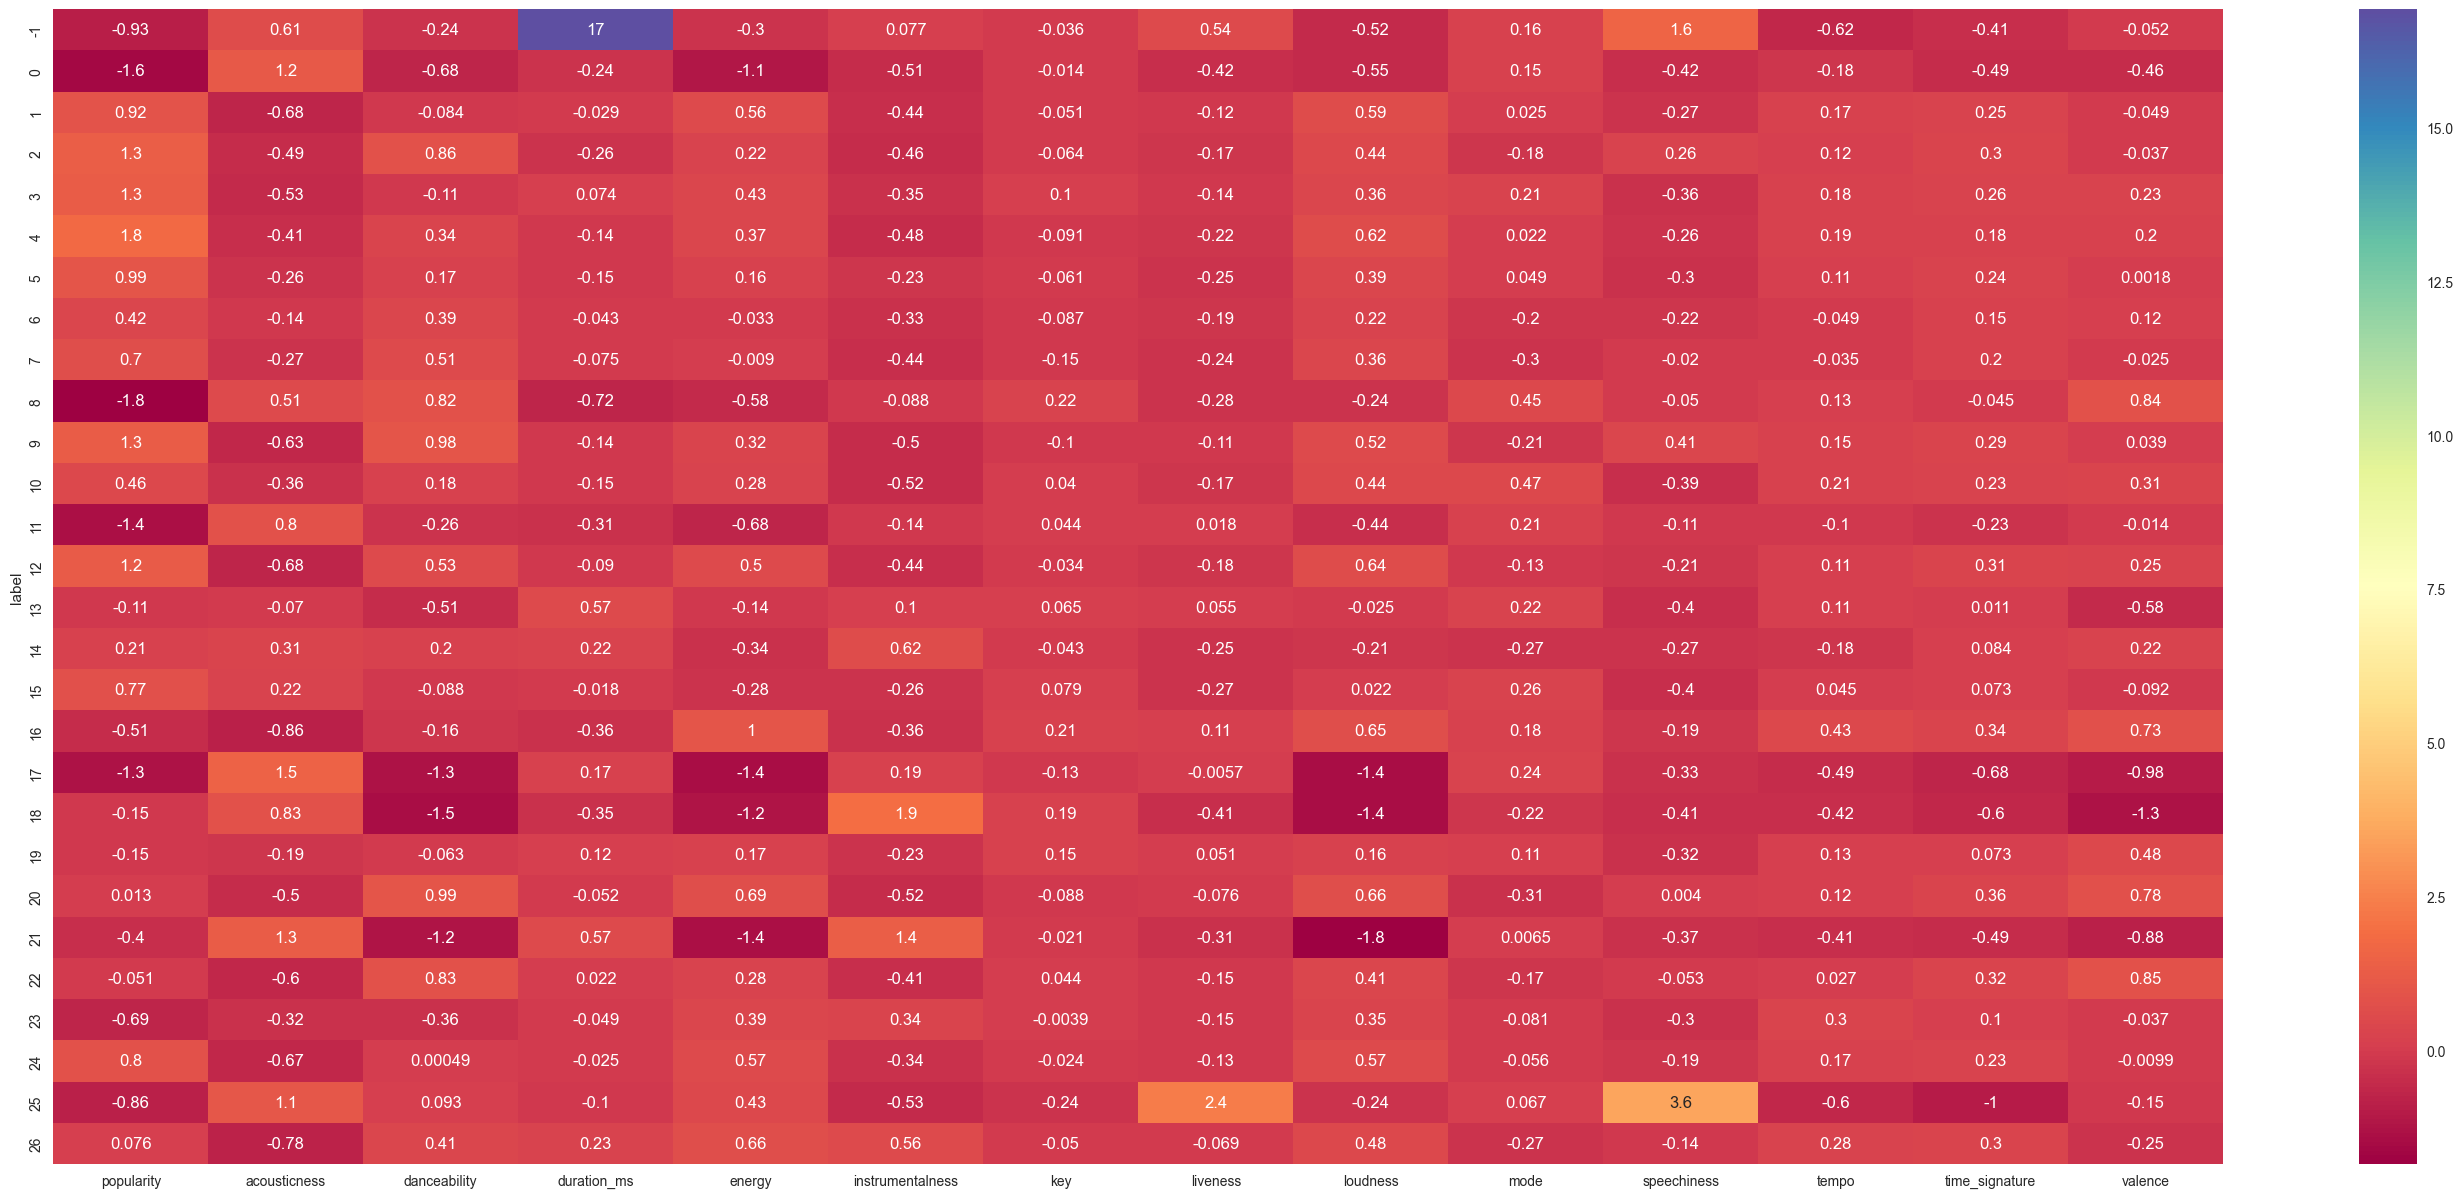

In [166]:
tmp = df3_hdbscan3.groupby(by=["label"]).mean()
plt.figure(figsize=(35, 15))
sns.heatmap(tmp.drop(feature_names, axis=1), cmap="Spectral", annot=True)

<Axes: ylabel='label'>

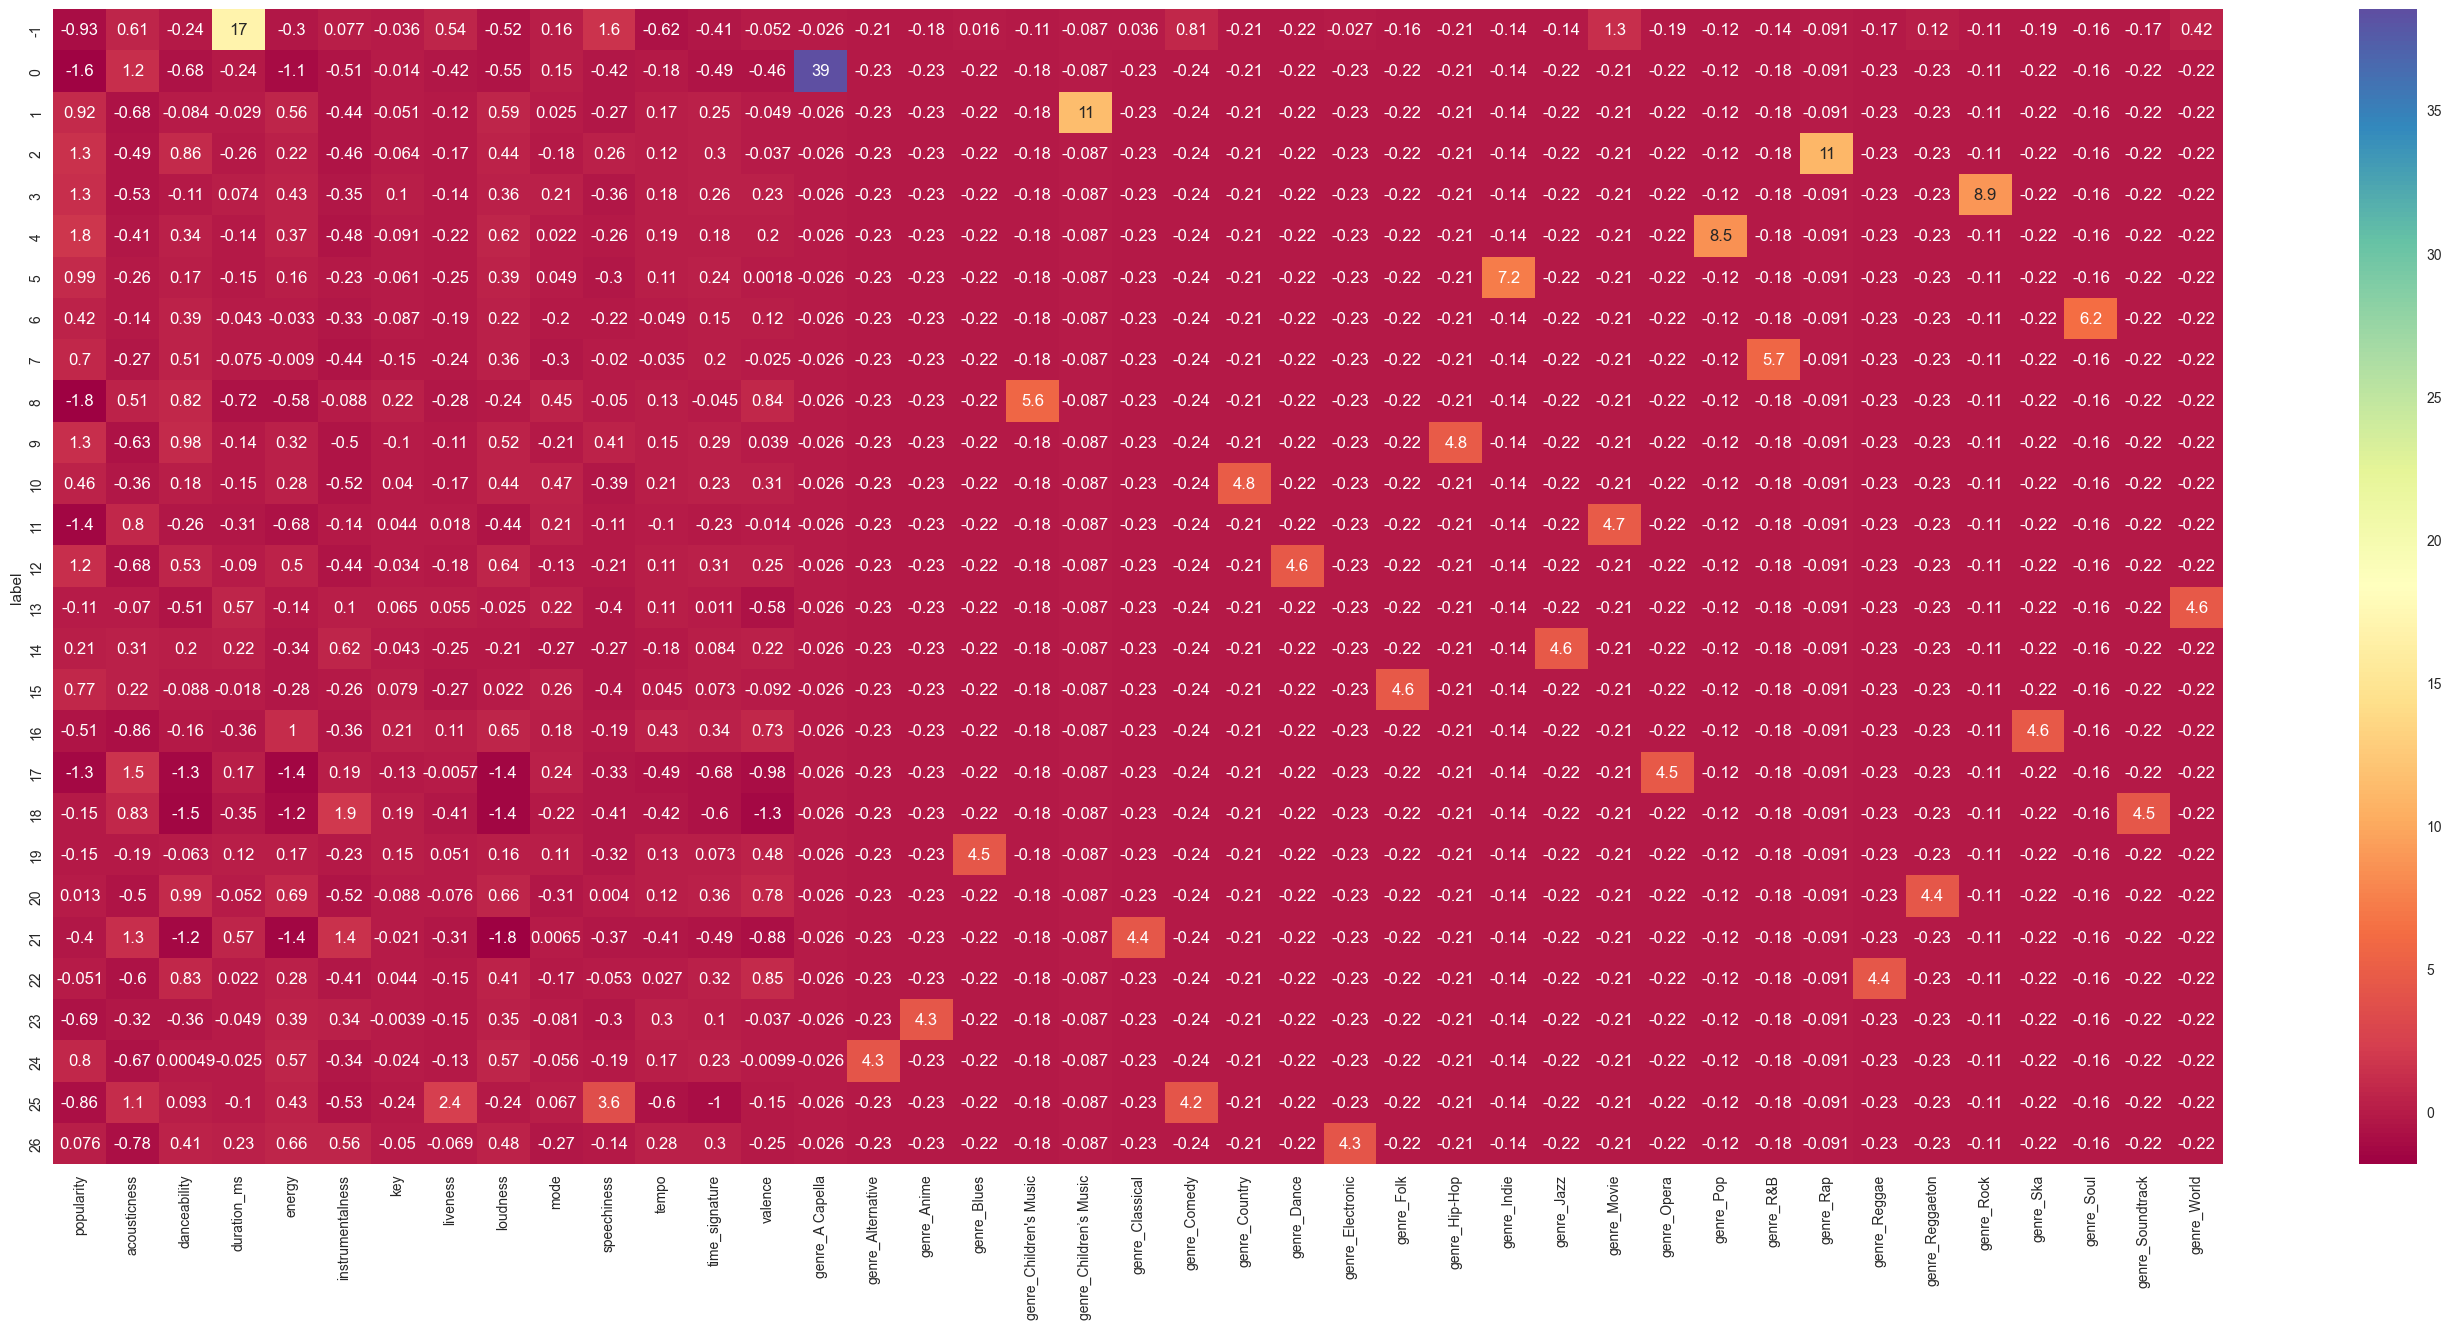

In [206]:
plt.figure(figsize=(35, 15))
sns.heatmap(tmp, cmap="Spectral", annot=True)

<Axes: ylabel='label'>

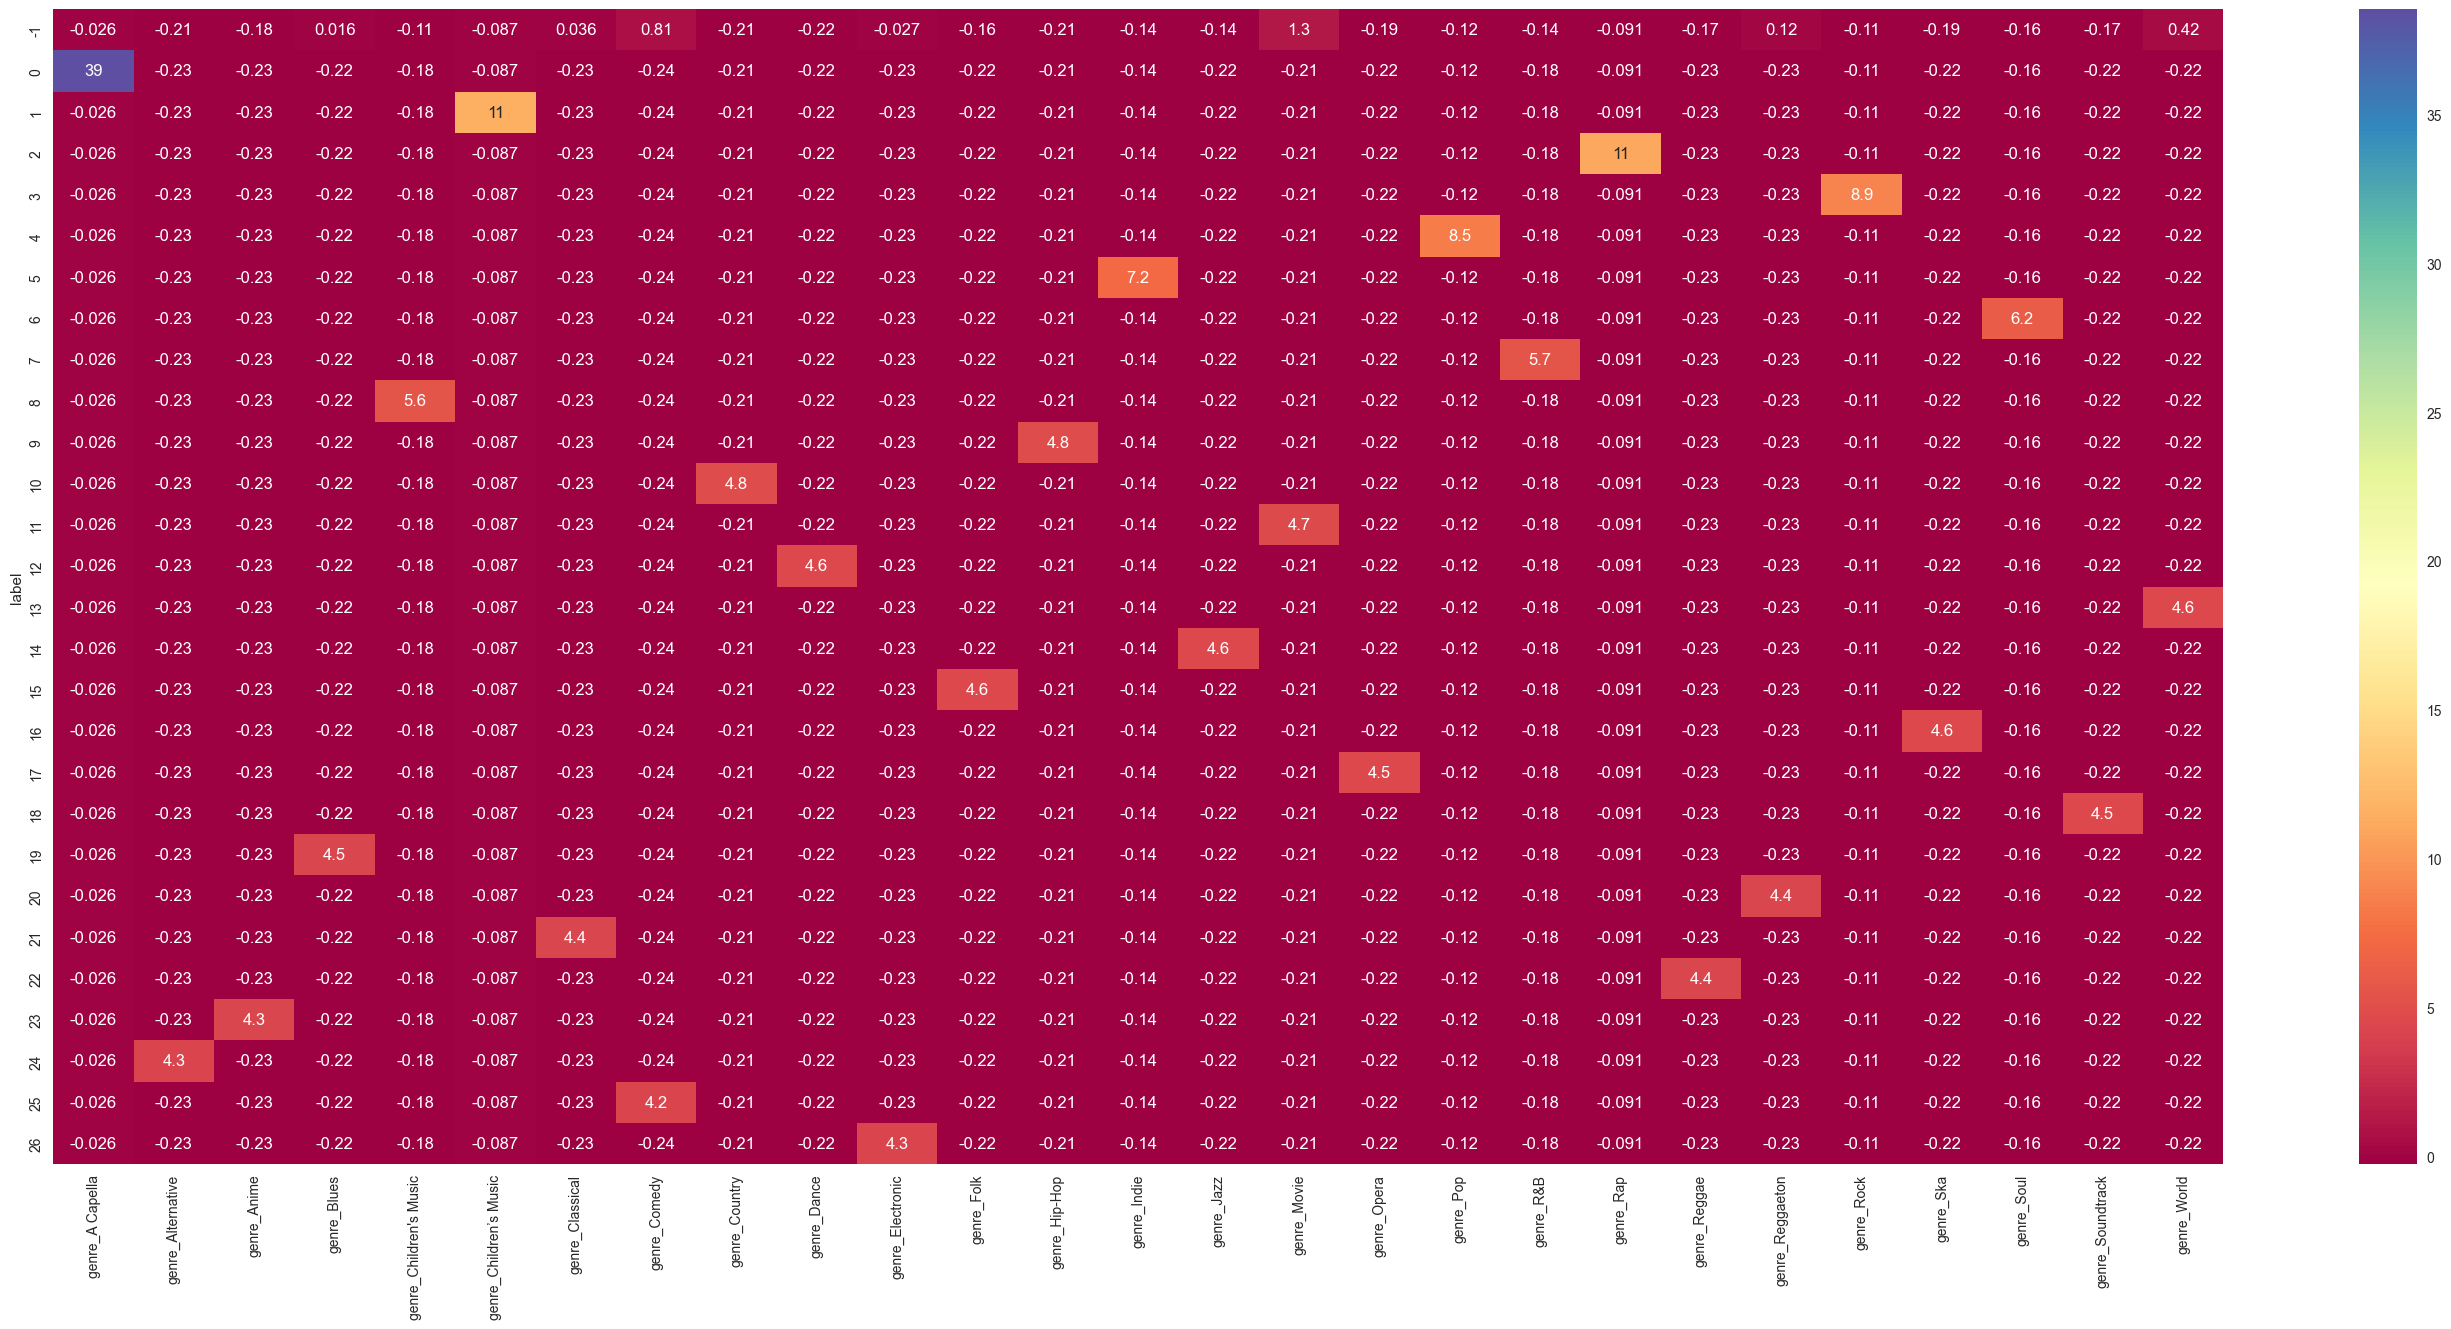

In [179]:
plt.figure(figsize=(35, 15))
sns.heatmap(tmp.drop(df.columns[1:], axis=1), cmap="Spectral", annot=True)

In [237]:
sum(df3[df3_hdbscan3["label"] == 0]["genre_A Capella"] ==  df3[df3["genre_A Capella"] == 1]["genre_A Capella"])

119